In [28]:
!pip install pyDOE

In [2]:
import tensorflow as tf
#import tensorflow_probability as tfp
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs,
# and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
#import seaborn as sns
#import codecs, json
import pandas as pd

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.6.2


$\frac{\partial p(x,t)}{\partial t} = \frac{\partial}{\partial x}
\left[\frac{m\omega^2}{\gamma} x \,p(x,t)+ D \frac{\partial p(x,t)}{\partial x}\right] \qquad A= \frac{m\omega^2}{\gamma}$

# Data Prep

The training and Testing data is prepared.

In [3]:
from scipy.stats import norm
# Defining the domain
x_lower = -1
x_upper = 1
x = np.linspace(x_lower, x_upper, 256)
dx = (x_upper - x_lower) / 256
t_lower = 0
t_upper = 0.1
t = np.linspace(t_lower, t_upper, 100)
dt = (t_upper - t_lower) / 100
psol=np.zeros((256,100)) #NOT COMPUTED YET ############CHECK
psol[:,0]=norm.pdf(x,0.5,0.05).T #INITIAL CONDITION

# All domain points
X, T = np.meshgrid(x,t)

A=10
D=0.1

## *Test Data*

We take the numerical solutions of the ```fplanck``` package as the test data to compare against the solution produced by the PINN.

In [4]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_p_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) # Need numerical solution here

# Domain bounds
low_bound = np.array([x_lower, t_lower]) 
up_bound = np.array([x_upper, t_upper])

'''
stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   p =  [25600x1]
'''
p = psol.flatten('F')

## *Training Data*

The boundary and initial conditions serve as the training data for the PINN. We also select the collocation points
using *Latin Hypercube Sampling*.

In [5]:
def trainingdata(N_bc, N_ic, N_f):
    """ Initial Condition"""

    #Initial Condition -1 =< x =<1 and t = 0  
    all_ic_x = np.vstack((X[0,:], T[0,:])).T
    all_ic_p = psol[:,0].reshape(len(psol[:,0]),1)
     
    '''Boundary Conditions'''

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.vstack((X[:,0], T[:,0])).T
    #bottomedge_p = psol[-1,:].reshape(len(psol[-1,:]),1)

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.vstack((X[:,-1], T[:,0])).T
    #topedge_p = psol[0,:].reshape(len(psol[0,:]),1)


    all_bc_x=np.vstack([bottomedge_x, topedge_x])
    # Reflecting conditions do not use the value of p
    #all_bc_p_train = np.vstack([ bottomedge_p, topedge_p])  

    #choose random N_bc and N:ic points for training
    index_bc = np.random.choice(all_bc_x.shape[0], N_bc, replace=False) 
    index_ic = np.random.choice(all_ic_x.shape[0], N_ic, replace=False)

    x_bc_train = all_bc_x[index_bc, :] 
    x_ic_train = all_ic_x[index_ic, :] 
    p_ic_train = all_ic_p[index_ic,:]    

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x_f_train = low_bound + (up_bound-low_bound)*lhs(2,N_f)
    # Do we select boundary and initial points also for f calculation?
    #x_f_train = np.vstack((x_f_train, x_bc_train, x_ic_train))
    
    '''Normalization Instants'''
    x_norm_instant = np.vstack((X[50,:],
                                T[50,:])).T
    
    return x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instant


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [6]:
class Sequentialmodel(tf.Module): 
    def __init__(self,
                 layers,
                 low_bound, up_bound,
                 x_ic_train, p_ic_train,
                 x_bc_train,
                 x_f_train,
                 x_norm_instants,
                 name = "FP-PINN",
                 A = 10,
                 D = 0.1,
                 doPrint = True,
                 additional_constraints = ()):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.epoch = 0
        self.doPrint = doPrint
        self.callback_after_n = 1000
        self.history = {"epoch": [],
                        "Total loss": [],
                        "IC loss": [],
                        "BC loss": [],
                        "f loss": [],
                        "Pr loss": [],
                        "Norm loss": [],
                        "Equi loss": []}


        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    
    def evaluate(self,x):
        
        x = (x-low_bound)/(up_bound-low_bound) # Normalization
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 


    def get_training_history(self):
        return self.history

    # Satisfy the IC
    def loss_IC(self, ic_points, p_ic_train):
        return tf.reduce_mean(tf.square(p_ic_train - self.evaluate(ic_points))) # MSE_ic


    # Reflecting boundary
    def loss_BC(self, bc_points):
        variable_bc = tf.Variable(bc_points, dtype = 'float64', trainable = False)

        x_bc = variable_bc[:,0:1]
        t_bc = variable_bc[:,1:2]
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_bc)
            tape.watch(t_bc)

            tensor_bc = tf.stack([x_bc[:,0], t_bc[:,0]], axis=1)   

            output_p_bc = self.evaluate(tensor_bc)
        p_x = tape.gradient(output_p_bc,x_bc)  #more efficient out of the context

        del tape

        J = -1 * (A * x_bc * output_p_bc + D * p_x)

        return tf.reduce_mean(tf.square(J)) # MSE_bc

    # Satisfy the PDE at the collocation points
    def loss_PDE(self, collocation_points):
    
        variable_collocation = tf.Variable(collocation_points, dtype = 'float64', trainable = False)

        x_f = variable_collocation[:,0:1]
        t_f = variable_collocation[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            tensor_collocation = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            output_p_collocation = self.evaluate(tensor_collocation)
            p_x = tape.gradient(output_p_collocation,x_f) #inside the context bc we need it for higher derivative
        p_t = tape.gradient(output_p_collocation,t_f)    
        p_xx = tape.gradient(p_x, x_f)  

        del tape

        f = p_t - A * output_p_collocation - A * x_f * p_x - D * p_xx

        return tf.reduce_mean(tf.square(f)) # MSE_f


    # Satisfy probabilty norm at some instants
    def loss_NORM(self, instants):
        o = self.evaluate(instants)
        return tf.abs(tf.reduce_sum(o) * dx - 1.0) # ME |norm - 1|

    # Must be Boltzmann at t >> 1 with ß * m * w ** 2 = A / D
    def loss_EQUI(self):
        t_large = (1 / A) * 10 * np.ones(256).reshape(256,1) # Typical time is 1 / A.
        x_domain = np.linspace(low_bound[0], up_bound[0], 256).reshape(256, 1)
        x_at_large_t = tf.stack([x_domain[:,0], t_large[:,0]], axis=1)
        output = self.evaluate(x_at_large_t)
        boltzmann_dist = tf.exp(-1 * (A/(2*D)) * x_domain ** 2)
        z = tf.reduce_sum(boltzmann_dist) * dx
        boltzmann_dist = boltzmann_dist / z
        # L2 norm (Boltzmann_dist - output)
        return tf.reduce_mean(tf.square(boltzmann_dist - output) * dx)


    # Satisfy p > 0 at IC and the collocation points
    def loss_PROB(self, ic_points, collocation_points):
        o1 = self.evaluate(ic_points)
        o2 = self.evaluate(collocation_points)
        negatives = tf.where(tf.greater_equal(o1, 0.),
                             tf.zeros_like(o1),
                             o1)
        loss_pr = tf.abs(tf.reduce_mean(negatives)) # MSE (p < 0) at IC
        negatives = tf.where(tf.greater_equal(o2, 0.),
                             tf.zeros_like(o2),
                             o2)
        loss_pr = loss_pr + tf.abs(tf.reduce_mean(negatives)) # MSE (p < 0) at collocation
        return loss_pr


    def loss(self):
        loss_ic = self.loss_IC(x_ic_train, p_ic_train)
        loss_bc = self.loss_BC(x_bc_train)
        loss_f = self.loss_PDE(x_f_train)
        loss_prob = self.loss_PROB(x_ic_train, x_f_train)
        loss_norm = self.loss_NORM(x_norm_instants)
        loss_equi = self.loss_EQUI()
        loss = loss_ic + loss_bc + loss_f
        if "prob" in additional_constraints:
            loss = loss + loss_prob
        if "norm" in additional_constraints:
            loss = loss + loss_norm
        if "equi" in additional_constraints:
            loss = loss + loss_equi
        return loss, loss_ic, loss_bc, loss_f, loss_prob, loss_norm, loss_equi
    
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            total_loss, loss_ic, loss_bc, loss_f, loss_pr, loss_norm, loss_equi = self.loss()
            grads = tape.gradient(total_loss,self.trainable_variables)
        if self.doPrint:
            self.epoch += 1
            tf.print(f"epoch: {self.epoch}", f"- Total: {total_loss:5.4e}", f"IC: {loss_ic:5.4e}",
                     f"BC: {loss_bc:5.4e}", f"f: {loss_f:5.4e}", f"Norm: {loss_norm:5.4e}", f"equi: {loss_equi:5.4e}")
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        self.history["epoch"].append(self.epoch)
        self.history["Total loss"].append(float(total_loss))
        self.history["IC loss"].append(float(loss_ic))
        self.history["BC loss"].append(float(loss_bc))
        self.history["f loss"].append(float(loss_f))
        self.history["Pr loss"].append(float(loss_pr))
        self.history["Norm loss"].append(float(loss_norm))
        self.history["Equi loss"].append(float(loss_equi))

        return total_loss.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
        if self.epoch % self.callback_after_n == 0:
            save_train_history(self)
            save_model_weights(self)


In [7]:
def solutionplot(p_pred,X_p_train):#,p_train):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.05, bottom=1-1/3, left=0.1, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(p_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    #ax.plot(X_p_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    #line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$p(x,t)$', fontsize = 10)

    
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=2/3-1/5, bottom=0.05, left=0.2, right=0.8, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs1[0, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[50,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.05s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[75,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.075s$', fontsize = 10)
    
    plt.tight_layout()
    #plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)
    

In [8]:
import numpy
def save_train_history(NN):
    TRAIN_HISTORY = NN.get_training_history()
    data_filename = "./data/TRAIN_HISTORY_"
    if len(additional_constraints) != 0:
        for constrain in additional_constraints:
            data_filename = data_filename + constrain + "_"
    data_filename = data_filename + f"IC{N_ic}_BC{N_bc}_f{N_f}_t{t_upper}_iter{maxiter}"
    pd.DataFrame(TRAIN_HISTORY).to_csv(data_filename)

def save_model_weights(NN):
    model_filename = "./models/MODEL_WEIGHTS_"
    if len(additional_constraints) != 0:
        for constrain in additional_constraints:
            model_filename = model_filename + constrain + "_"
    model_filename = model_filename + f"IC{N_ic}_BC{N_bc}_f{N_f}_t{t_upper}_iter{maxiter}"
    numpy.savetxt(model_filename, NN.get_weights().numpy())


# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [9]:
N_bc = 100 #Total number of boundary conditions points
N_ic = 100 #Total number of initial condition points
N_f = 1000 #Total number of collocation points

# Training data
x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instants = trainingdata(N_bc, N_ic, N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

# Put 'norm', 'prob' or 'equi' on the following tuple to add to the total loss the normalization loss,
#   negative probability loss, or Boltzmann equilibrium distribution loss respectively.
additional_constraints = ["equi"]

PINN = Sequentialmodel(layers, low_bound, up_bound,
                       x_ic_train, p_ic_train,
                       x_bc_train,
                       x_f_train,
                       x_norm_instants,
                       additional_constraints=additional_constraints)

init_params = PINN.get_weights().numpy()

start_time = time.time() 
# train the model with Scipy L-BFGS optimizer
#tfp.optimizer.lbfgs_minimize
maxiter = 50000
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8,
                                            'maxfun':  50000, 
                                            'maxiter': maxiter,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
elapsed = time.time() - start_time                
print('Training time: %.2f' % elapsed)

print(results)

PINN.set_weights(results.x)

''' Model Accuracy '''
p_pred = PINN.evaluate(X_p_test)


p_pred = np.reshape(p_pred,(256,100),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
solutionplot(p_pred,X_p_test)


2022-05-24 07:50:57.137571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 07:50:57.137621: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


"\nresults = scipy.optimize.minimize(fun = PINN.optimizerfunc, \n                                  x0 = init_params, \n                                  args=(), \n                                  method='L-BFGS-B', \n                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function\n                                  callback = PINN.optimizer_callback, \n                                  options = {'disp': None,\n                                            'maxcor': 200, \n                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol\n                                            'gtol': 5e-8,\n                                            'maxfun':  50000, \n                                            'maxiter': maxiter,\n                                            'iprint': -1,   #print update every 50 iterations\n          

In [ ]:
save_train_history(NN)
save_model_weights(NN)

## Comparison with numerical solution

## Prediction for large t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_141/322358057.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


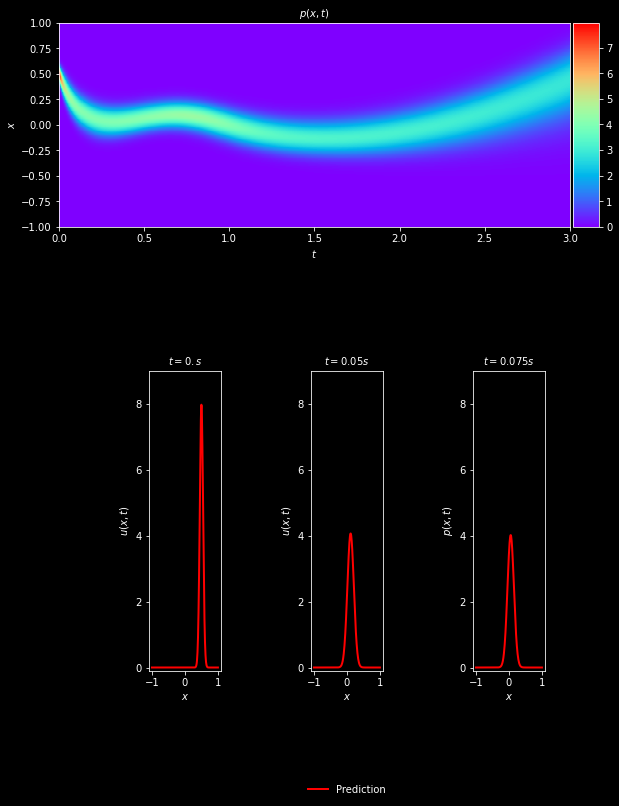

In [34]:
x_lower = -1
x_upper = 1
x = np.linspace(x_lower, x_upper, 256)
t_lower = 0
t_upper = 3
t = np.linspace(t_lower, t_upper, 1000)
psol=np.zeros((256,1000)) #NOT COMPUTED YET
psol[:,0]=norm.pdf(x,0.5,0.05).T #INITIAL CONDITION

#collocation points for every position and every time
X, T = np.meshgrid(x,t)
X_p_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
p_pred = PINN.evaluate(X_p_test)


p_pred = np.reshape(p_pred,(256,1000),order='F')
solutionplot(p_pred,X_p_test)

## Training History

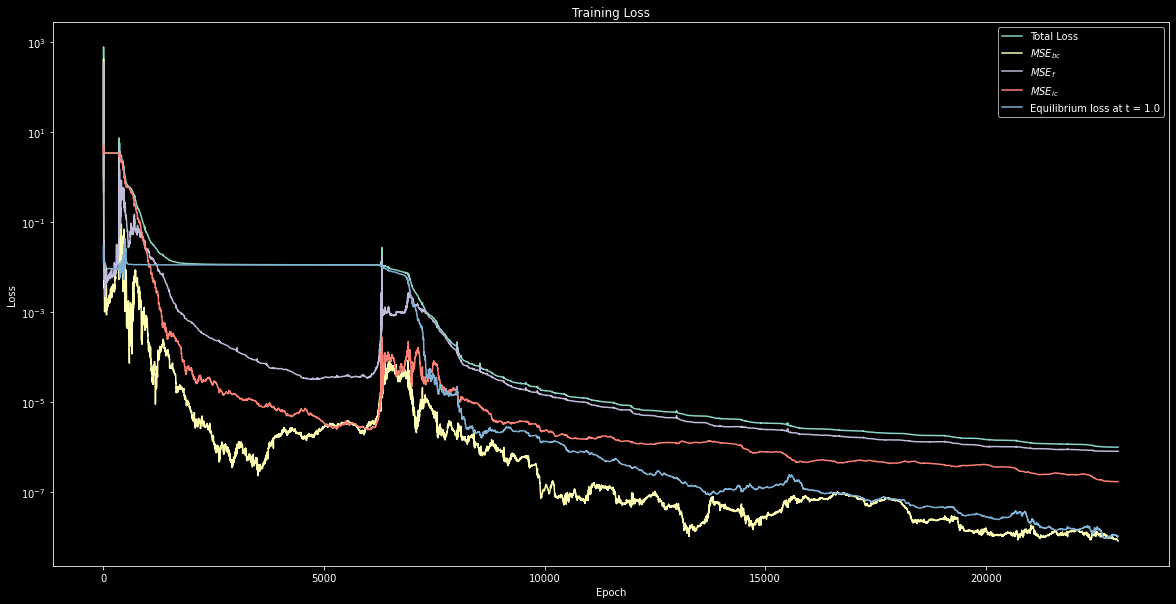

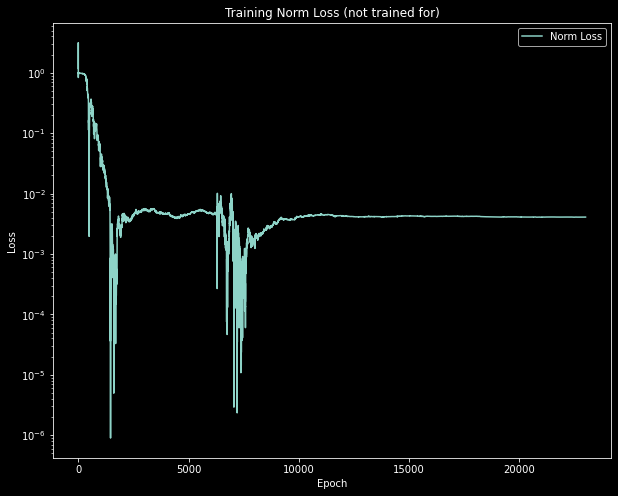

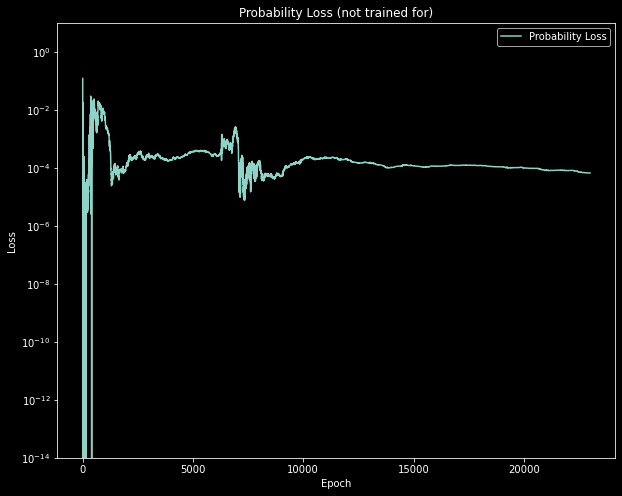

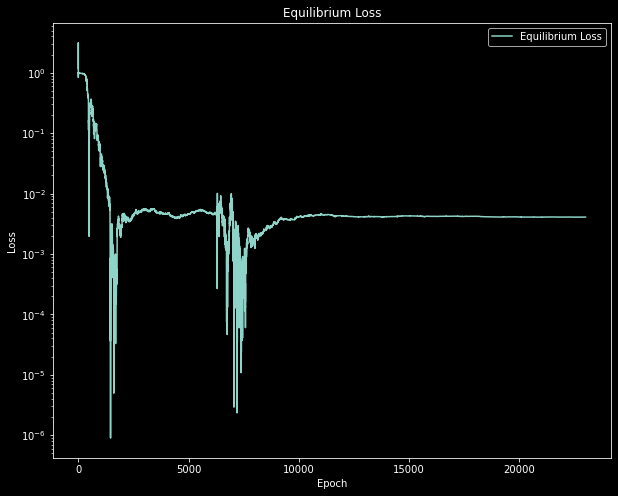

In [27]:
plt.style.use("dark_background")
plt.figure(figsize=(20,10))
plt.title("Training Loss")
df = pd.read_csv("./data/TRAIN_HISTORY_equi_IC100_BC100_f1000_t0.1_iter50000")
plt.plot(df["epoch"], df["Total loss"], label="Total Loss")
plt.plot(df["epoch"], df["BC loss"], label="$MSE_{bc}$")
plt.plot(df["epoch"], df["f loss"], label="$MSE_f$")
plt.plot(df["epoch"], df["IC loss"], label="$MSE_{ic}$")
plt.plot(df["epoch"], df["Equi loss"], label="Equilibrium loss at t = 1.0")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Training Norm Loss (not trained for)")
#plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df["epoch"], df["Norm loss"], label = "Norm Loss")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Probability Loss (not trained for)")
plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.ylim((10 ** -14, 10 ** 1))
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Equilibrium Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df["epoch"], df["Norm loss"], label = "Equilibrium Loss")
plt.yscale("log")
plt.legend()
plt.show()